# Process the Health Data and Blood Sugar Data

## Extract Apple Health Data and Export to CSVs
* Command Line Tool to Process apple health's export.xml file 
* Create multiple CSV files for each data type. 
* Original Source: https://github.com/tdda/applehealthdata
### Setup and Usage
* Export your data from Apple Health App on your phone. 
* Unzip export.zip into the DATA directory.
* Inside your directory there should be a directory and file here: /DATA/export/apple_health_export/export.xml
* Run the following command

In [ ]:
%run -i apple-health-data-parser.py DATA/export/apple_health_export/export.xml

## Process Active Calorie Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
calories = pd.read_csv(r'DATA\export\apple_health_export\ActiveEnergyBurned.csv')

In [4]:
calories.tail()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
1453638,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x303312620>, name:Apple Watch, ma...",ActiveEnergyBurned,Cal,2024-06-12 11:35:26 -0700,2024-06-12 11:25:00 -0700,2024-06-12 11:34:51 -0700,2.430
1453639,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x303312620>, name:Apple Watch, ma...",ActiveEnergyBurned,Cal,2024-06-12 11:47:09 -0700,2024-06-12 11:35:01 -0700,2024-06-12 11:35:11 -0700,0.079
1453640,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x303312620>, name:Apple Watch, ma...",ActiveEnergyBurned,Cal,2024-06-12 11:48:31 -0700,2024-06-12 11:38:04 -0700,2024-06-12 11:47:35 -0700,1.322
1453641,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x303312620>, name:Apple Watch, ma...",ActiveEnergyBurned,Cal,2024-06-12 11:59:04 -0700,2024-06-12 11:48:26 -0700,2024-06-12 11:58:17 -0700,1.090
1453642,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x303312620>, name:Apple Watch, ma...",ActiveEnergyBurned,Cal,2024-06-12 12:09:21 -0700,2024-06-12 11:59:18 -0700,2024-06-12 12:09:10 -0700,4.267


In [5]:
calories.describe()

,value
count,1.453643e+06
mean,9.302784e-01
std,5.062170e+00
min,2.000000e-03
25%,1.680000e-01
50%,3.170000e-01
75%,4.800000e-01
max,1.431340e+02


In [6]:
# number of calories all time
calories.value.sum()

1352292.6919999996

## Test Visualization Using Steps

In [3]:
from datetime import datetime
import pytz

In [4]:
steps = pd.read_csv(r'DATA\export\apple_health_export/StepCount.csv')
steps.tail()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
250709,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 09:49:33 -0700,2024-06-12 09:38:50 -0700,2024-06-12 09:38:55 -0700,19
250710,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 10:15:04 -0700,2024-06-12 10:03:38 -0700,2024-06-12 10:03:48 -0700,20
250711,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 10:24:50 -0700,2024-06-12 10:13:47 -0700,2024-06-12 10:14:50 -0700,18
250712,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 11:35:26 -0700,2024-06-12 11:24:39 -0700,2024-06-12 11:25:53 -0700,37
250713,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 12:13:37 -0700,2024-06-12 12:02:35 -0700,2024-06-12 12:10:41 -0700,139


In [27]:
# convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('America/Vancouver'))
convert_tz = lambda x: x
get_year = lambda x: (dt := convert_tz(x)).year
get_month = lambda x: (dt := convert_tz(x)) and f'{dt.year}-{dt.month:02}'
get_date = lambda x: (dt := convert_tz(x)) and f'{dt.year}-{dt.month:02}-{dt.day:02}'
get_day = lambda x: convert_tz(x).day
get_hour = lambda x: convert_tz(x).hour
get_day_of_week = lambda x: convert_tz(x).weekday()

steps['startDate'] = pd.to_datetime(steps['startDate'])
steps['year'] = steps['startDate'].map(get_year)
steps['month'] = steps['startDate'].map(get_month)
steps['date'] = steps['startDate'].map(get_date)
steps['day'] = steps['startDate'].map(get_day)
steps['hour'] = steps['startDate'].map(get_hour)
steps['dow'] = steps['startDate'].map(get_day_of_week)

In [28]:
steps = steps[steps.sourceName == 'Tyler’s Apple\xa0Watch']
steps.tail()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value,year,month,date,day,hour,dow
250709,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 09:49:33 -0700,2024-06-12 09:38:50-07:00,2024-06-12 09:38:55 -0700,19,2024,2024-06,2024-06-12,12,9,2
250710,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 10:15:04 -0700,2024-06-12 10:03:38-07:00,2024-06-12 10:03:48 -0700,20,2024,2024-06,2024-06-12,12,10,2
250711,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 10:24:50 -0700,2024-06-12 10:13:47-07:00,2024-06-12 10:14:50 -0700,18,2024,2024-06,2024-06-12,12,10,2
250712,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 11:35:26 -0700,2024-06-12 11:24:39-07:00,2024-06-12 11:25:53 -0700,37,2024,2024-06,2024-06-12,12,11,2
250713,Tyler’s Apple Watch,10.5,"<<HKDevice: 0x3033134d0>, name:Apple Watch, ma...",StepCount,count,2024-06-12 12:13:37 -0700,2024-06-12 12:02:35-07:00,2024-06-12 12:10:41 -0700,139,2024,2024-06,2024-06-12,12,12,2


In [29]:
steps_by_date = steps.groupby(['date'])['value'].sum().reset_index(name='Steps')
steps_by_date.tail()

,date,Steps
1443,2024-06-08,18868
1444,2024-06-09,22955
1445,2024-06-10,7505
1446,2024-06-11,13286
1447,2024-06-12,299


In [30]:
steps_by_date.describe()

,Steps
count,1448.000000
mean,12238.957873
std,6358.723010
min,32.000000
25%,8042.500000
50%,11483.000000
75%,15761.750000
max,47209.000000


<AxesSubplot: xlabel='hour'>

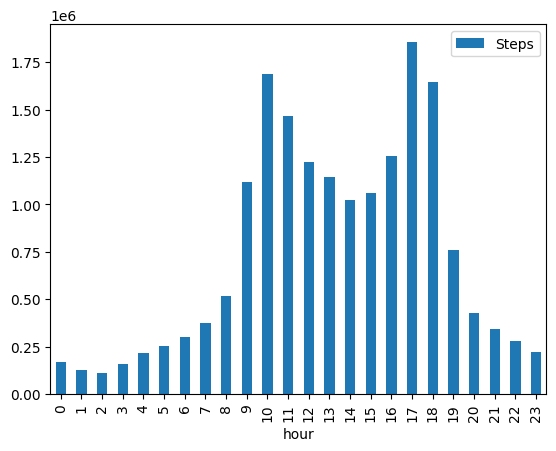

In [31]:
# plot steps by hour of the day
steps_by_hour = steps.groupby(['hour'])['value'].sum().reset_index(name='Steps')
steps_by_hour.plot(x='hour', y='Steps', kind='bar')

<AxesSubplot: xlabel='dow'>

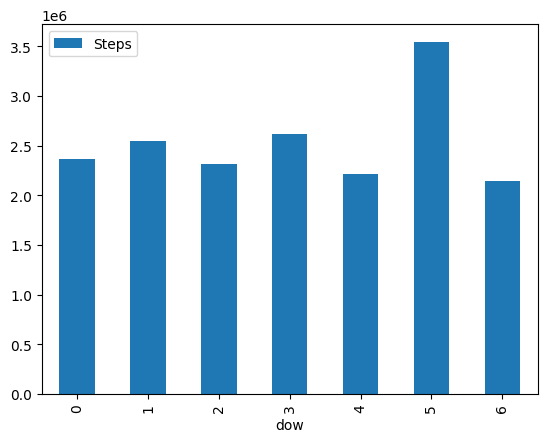

In [34]:
# plot steps by days of the week
steps_by_hour = steps.groupby(['dow'])['value'].sum().reset_index(name='Steps')
steps_by_hour.plot(x='dow', y='Steps', kind='bar')